# 0. data prepare

In [1]:
import os
import shutil


def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

market_dir = '/home/hui/dataset/market1501/'
save_dir = market_dir + "/features"
force_regenerate = False
if force_regenerate or (not os.path.exists(market_dir + 'classify/')):
    classfy_dir = os.path.join(market_dir, 'classify/')
    mkdir_if_not_exist([classfy_dir])
    images_dir = market_dir + 'bounding_box_train'
    for i, image_name in enumerate(os.listdir(images_dir)):
        if image_name.split('.')[-1] != 'jpg': continue
        person_id = image_name.split('_')[0]
        mkdir_if_not_exist([classfy_dir, person_id])
        shutil.copy(os.path.join(images_dir, image_name), os.path.join(classfy_dir, person_id))
        if i % 1000==0: print i, image_name, person_id

# 1. import needed package

In [2]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
from cifar10_utils import show_images, show_log, parse_log, update
%matplotlib inline
import mxnet.gluon.model_zoo.vision as models
from tqdm import tqdm
from reid_utils import *

ctx = mx.gpu(0)
num_classes = 751
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [3]:
"""
data loader
"""
batch_size = 16
# imagenet mean and std, set None or not set will use as default for image.CreateAugmenter function
mean = np.array([123.68, 116.28, 103.53])
std = np.array([58.395, 57.12, 57.375])

def _transform_test(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(128, interp=3),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255
    return im, nd.array([label]).astype('float32')

def _transform_test2(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(144, interp=3),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255
    return im, nd.array([label]).astype('float32')

def _transform_test_flip(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(128, interp=3),
               image.HorizontalFlipAug(1),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255
    return im, nd.array([label]).astype('float32')

def _transform_test2_flip(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(144, interp=3),
               image.HorizontalFlipAug(1),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255
    return im, nd.array([label]).astype('float32')

def inv_normalize(data, clip=True):
    images = data.transpose((0, 2, 3, 1)).asnumpy()  * 255
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2))
    if clip: 
        images = images.clip(0, 255)
    return images

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.ImageFolderDataset(root=market_dir + '/classify/', flag=1, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    #test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    #test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, None

In [4]:
"""
data argument
"""
from PIL import Image
import random
import math
import numpy as np
import torch

class RandomErasing(object):
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf
    Args:
         probability: The probability that the Random Erasing operation will be performed.
         sl: Minimum proportion of erased area against input image.
         sh: Maximum proportion of erased area against input image.
         r1: Minimum aspect ratio of erased area.
         mean: Erasing value. 
    """
    
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0, 0, 0]):
        self.probability = probability
        self.mean = nd.array(mean)
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.shape[0] * img.shape[1]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.shape[1] and h < img.shape[0]:
                x1 = random.randint(0, img.shape[0] - h)
                y1 = random.randint(0, img.shape[1] - w)
                if img.shape[2] == 3:
                    img[x1:x1+h, y1:y1+w, 0] = self.mean[0]
                    img[x1:x1+h, y1:y1+w, 1] = self.mean[1]
                    img[x1:x1+h, y1:y1+w, 2] = self.mean[2]
                else:
                    img[x1:x1+h, y1:y1+w, 0] = self.mean[0]
                return img

        return img

def transform_train_DA1(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(144, interp=3),
               image.RandomCropAug((128, 256)),   # w, h
               image.HorizontalFlipAug(0.5),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255# channel x width x height
    return im, nd.array([label]).astype('float32')

def transform_train_DA2(data, label):
    im = data.astype('float32')
    auglist = [image.ResizeAug(144, interp=3),
               image.RandomCropAug((128, 256)),   # w, h
               image.HorizontalFlipAug(0.5),
               image.ColorJitterAug(brightness=0.1, contrast=0.1, saturation=0.1),
               RandomErasing(),
               image.ColorNormalizeAug(mean=mean, std=std)]
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) / 255# channel x width x height
    return im, nd.array([label]).astype('float32')

In [5]:
train_data, _ = data_loader(batch_size, _transform_test)

(16L, 3L, 256L, 128L)


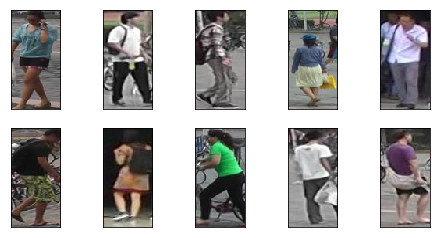

In [40]:
for data, label in train_data:
    break
print data.shape
show_images(inv_normalize(data[:10, :, :, :]))

In [70]:
train_data, _ = data_loader(batch_size, transform_train_DA2)

(16L, 3L, 256L, 128L)

[[ 403.  382.  411.   74.  154.  158.    8.  401.  602.  692.  126.  448.
   403.   93.  433.    5.]]
<NDArray 1x16 @cpu(0)>


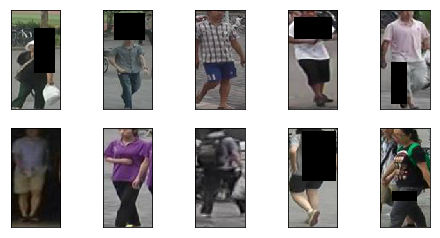

In [71]:
for data, label in train_data:
    break
print data.shape
print label.T
show_images(inv_normalize(data[:10, :, :, :]))

# 4. define train function

In [5]:
"""
train
"""
import datetime
import utils
import sys
from random import random

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2, back_grad_args=None, trainers=None, epoch_call_back=None):
    
    def train_batch(data, label, i, use_backgrad, loss_f):
        data = data.as_in_context(ctx)
        _label = label.copy()
        label = label.as_in_context(ctx)
        
        # generate backgrad data
        _bloss = None
        if use_backgrad:
            args = back_grad_args
            args['prob'] = args.get('prob', 1)      # prob to use back grad data argument to prove origin data is used.
            if random() <= args['prob']:
                args['max_iters'], args['lr'] = args.get('max_iters', 60), args.get('lr', 0.1)
                _data, (_bloss,) = generate_backgrad_data(args['net'], data, label, args['max_iters'], args['lr'], iter_log=False)
                if args.has_key('soft_label_th'):
                    label = get_soft_label(label, num_classes, args['soft_label_th'])
                    loss_f = args['soft_label_loss_f']
                    
                if args.has_key('show_iters') and i % args['show_iters'] == 0:
                    show_data(data[:5])
                    
                if args.has_key('attach_batch') and args['attach_batch'] == True:
                    data = nd.concat(data, _data, dim=0)
                    label = nd.concat(label, label, dim=0)
                    _label = nd.concat(_label, _label, dim=0)
                else:
                    data = _data
                    
        label = label.as_in_context(ctx)            
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        for trainer in trainers:
            trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
#         if not use_mixup and (back_grad_args is None or not args.has_key('soft_label_th')):
#             _acc = utils.accuracy(output, label)
        if not use_mixup:
            _acc = utils.accuracy(output, _label.as_in_context(ctx))
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc, _bloss
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    if trainers is None:
        trainers = [gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})]
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.
        train_acc = 0.
        bloss, btime = 0., 0
        if in_list(epoch, lr_period):
            for trainer in trainers:
                trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        
        # back grad
        use_backgrad = False
        if back_grad_args is not None:
            args = back_grad_args
            if args.has_key('take_turn'):
                args['take_turn'] = not args['take_turn'] # only odd epoch(start 0) will use back grad

            if (not args.has_key('take_turn')) or args['take_turn'] == True:
                if not args.has_key('prob'): print "# back grad turn." 
                use_backgrad = True
        
        # mixup
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc, _bloss = train_batch(data, label, i, use_backgrad, loss_f)
                train_loss += _loss
                if _acc is not None: train_acc += _acc
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _, _bloss = train_batch(data, label, i, use_backgrad, loss_f)
                train_loss += _loss
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        
        # log info
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
            
        if back_grad_args is not None:
            epoch_str += (", bloss %.5f" % (-bloss / btime))
            
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str([trainer.learning_rate for trainer in trainers]) + "\n")
        
        if epoch_call_back is not None:
            epoch_call_back(epoch, net)
            
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

In [6]:
def test_data_loader(batch_size, transform=None, num_workers=0):
    gallery_ds = MarketDataset(os.path.join(market_dir, 'bounding_box_test'), transform=transform)#, ignore_neg=False)
    gallery_data = gluon.data.DataLoader(gallery_ds, 16, shuffle=False, last_batch='keep', num_workers=num_workers)
    query_ds = MarketDataset(os.path.join(market_dir, 'query'), transform=transform)
    query_data = gluon.data.DataLoader(query_ds, 16, shuffle=False, last_batch='keep', num_workers=num_workers)
    return gallery_data, query_data

def get_features(net, dataloader, show_process=False):
    features, labels, cams = None, None, None
    for data, label, cam in dataloader:
        feature = net(data.as_in_context(ctx))
        feature = feature.reshape((feature.shape[0], -1))
        if features is None:
            features, labels, cams = feature.copy(), label.copy(), cam.copy()
        else:
            features = nd.concat(features, feature, dim=0)
            labels = nd.concat(labels, label, dim=0)
            cams = nd.concat(cams, cam, dim=0)
    if show_process: print "process all %d images over" % features.shape[0]
    return features.asnumpy(), labels.astype('int32').asnumpy(), cams.astype('int32').asnumpy()
        
def save_features_of_dir(net, dataloader, save_prefix):
    features, labels, cams = get_features(net, dataloader, True)
    np.save(save_prefix + 'features', features)
    np.save(save_prefix + 'labels', labels)
    np.save(save_prefix + 'cams', cams)
    print "all done."
    
from reid_evaluate import evaluate
from sklearn.preprocessing import normalize
def cal_CMC(args, flip=None):
    """
    arg:
        str, prerix of saved npy file.
        list, [net, query_dir, gallery_dir]
    """
    if isinstance(args, str):
        prefix = args
        query_feature = np.load(prefix + 'q_features.npy')
        query_cam = np.load(prefix + 'q_cams.npy')
        query_label = np.load(prefix + 'q_labels.npy')
        gallery_feature = np.load(prefix + 'g_features.npy')
        gallery_cam = np.load(prefix + 'g_cams.npy')
        gallery_label = np.load(prefix + 'g_labels.npy')
        if flip is None:
            pass
        elif flip.lower() == 'add':
            query_feature += np.load(prefix + 'q_flip_features.npy')
            gallery_feature += np.load(prefix + 'g_flip_features.npy')
    elif isinstance(args, list):
        if flip is None:
            net, query_data, gallery_data = args
            query_feature, query_label, query_cam = get_features(net, query_data)
            gallery_feature, gallery_label, gallery_cam = get_features(net, gallery_data)
        else:
            net, query_data, gallery_data, flip_query_data, flip_gallery_data = args
            query_feature, query_label, query_cam = get_features(net, query_data)
            gallery_feature, gallery_label, gallery_cam = get_features(net, gallery_data)
            flip_query_feature, _, _ = get_features(net, flip_query_data)
            flip_gallery_feature, _, _ = get_features(net, flip_gallery_data)
            if flip.lower() == 'add':
                query_feature += flip_query_feature
                gallery_feature += flip_gallery_feature
            if flip.lower() == 'concat':
                query_feature = np.concatenate([query_feature, flip_query_feature], axis=1)
                gallery_feature = np.concatenate([gallery_feature, flip_gallery_feature], axis=1)
                # print query_feature.shape
            if flip.lower() == 'attach':
                # query_feature = np.concatenate([query_feature, flip_query_feature], axis=1)
                gallery_feature = np.concatenate([gallery_feature, flip_gallery_feature], axis=0)
                gallery_label = np.concatenate([gallery_label, gallery_label], axis=0)
                gallery_cam = np.concatenate([gallery_cam, gallery_cam], axis=0)
    else:
        raise ValueError('wrong args')
        
    query_feature = normalize(query_feature, 'l2', axis=1)
    gallery_feature = normalize(gallery_feature, 'l2', axis=1)

    CMC = np.zeros(shape=(len(gallery_label),)) # torch.IntTensor(len(gallery_label)).zero_()
    ap = 0.0
    
    if isinstance(args, str):
        iters = tqdm(range(len(query_label)))
    else:
        iters = range(len(query_label))
    
    for i in iters:
        ap_tmp, CMC_tmp = evaluate(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
        if CMC_tmp[0]==-1:
            continue
        CMC = CMC + CMC_tmp
        ap += ap_tmp
        #print(i, CMC_tmp[0])

    CMC = CMC/len(query_label) #average CMC
    if isinstance(args, str): print('top1:%f top5:%f top10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap/len(query_label)))
    return CMC, ap/len(query_label)

def epoch_call_back(epoch, net):
    if (epoch + 1) % 10 == 0:
        CMC, ap = cal_CMC([net[0], query_data, gallery_data])
        CMC, ap = cal_CMC([net[0], query_data2, gallery_data2, flip_query_data2, flip_gallery_data2], flip='add')
        print('# top1:%f top5:%f top10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap))
        
        
gallery_data, query_data = test_data_loader(16, transform=_transform_test, num_workers=1)
flip_gallery_data, flip_query_data = test_data_loader(16, transform=_transform_test_flip, num_workers=1)

gallery_data2, query_data2 = test_data_loader(16, transform=_transform_test2, num_workers=1)
flip_gallery_data2, flip_query_data2 = test_data_loader(16, transform=_transform_test2_flip, num_workers=1)

../../utils/reid_utils.py:22: UserWarning: Ignoring /home/hui/dataset/market1501/bounding_box_test/Thumbs.db of type .db. Only support .ndarray, .jpeg, .jpg, .png
  filename, ext, ', '.join(self._exts)))
../../utils/reid_utils.py:22: UserWarning: Ignoring /home/hui/dataset/market1501/query/Thumbs.db of type .db. Only support .ndarray, .jpeg, .jpg, .png
  filename, ext, ', '.join(self._exts)))


In [7]:
def get_resnet50_v1(num_classes, pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = models.resnet50_v1(pretrained=pretrained, ctx=ctx)
        classify = nn.HybridSequential()
        with classify.name_scope():
            classify.add(nn.Dense(512)) # fc6
            classify.add(nn.BatchNorm())
            classify.add(nn.LeakyReLU(0.1))
            classify.add(nn.Dropout(0.5))
            classify.add(nn.Dense(num_classes)) # fc7
        net.add(resnet.features)
        net.add(classify)

    net.hybridize()
    if pretrained:
        classify.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

## 5.1 baseline: general lr policy train my resnet50

1. train_data shuffle is very important, will impove acc and converage speed signiture.
2. feature normalize is very important, if not only 0.35 rank acc get against 0.81.
3. 

### 5.1.1 sgd train 60 epoch

In [8]:
num_epochs = 60
learning_rate = 0.001
wd=weight_decay = 5e-4
lr_period = [40]
lr_decay=0.1
log_file = "../../log/market_resnet50_v1_60e.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()


train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=1)
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()

trainers = [gluon.Trainer(net[0].collect_params(), 'sgd', {'learning_rate': 0.01, 'momentum': 0.9, 'wd': wd}),
            gluon.Trainer(net[1].collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': wd})]

train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, trainers=trainers)

net.save_params("../../models/market_resnet50_v1_60e")

100%|██████████| 60/60 [1:31:08<00:00, 91.14s/it]


In [11]:
mkdir_if_not_exist([save_dir])
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_60e", ctx=ctx)
save_features_of_dir(net[0], gallery_data, save_dir + "/resnet50_g_")
save_features_of_dir(net[0], query_data, save_dir + "/resnet50_q_")
cal_CMC(save_dir + "/resnet50_")

process all 15913 images over
all done.
process all 3368 images over


  0%|          | 0/3368 [00:00<?, ?it/s]

all done.


100%|██████████| 3368/3368 [00:39<00:00, 86.30it/s]

top1:0.814727 top5:0.922506 top10:0.948931 mAP:0.599514


(array([ 0.81472684,  0.86876485,  0.89637767, ...,  1.        ,
         1.        ,  1.        ]), 0.5995140519840136)

### 5.1.2 finetune to 100 epoch

In [ ]:
num_epochs = 40
learning_rate = 0.001
wd=weight_decay = 5e-4
lr_period = [20]
lr_decay=0.1
log_file = "../../log/market_resnet50_v1_60e.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()


train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=1)
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.load_params('../../models/market_resnet50_v1_60e', ctx=ctx)
net.hybridize()

trainers = [gluon.Trainer(net[0].collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 0.9, 'wd': wd}),
            gluon.Trainer(net[1].collect_params(), 'sgd', {'learning_rate': 0.01, 'momentum': 0.9, 'wd': wd})]

train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, trainers=trainers, epoch_call_back=epoch_call_back)

net.save_params("../../models/market_resnet50_v1_100e")

In [10]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e", ctx=ctx)

CMC, ap = cal_CMC([net[0], query_data, gallery_data])
print CMC[0], ap

0.820961995249 0.60701936506


### 5.1.3 nag train 100 epoch with diffrent lr 

In [8]:
num_epochs = 100
learning_rate = 0.001
wd=weight_decay = 5e-4
lr_period = [40, 80]
lr_decay=0.1
log_file = "../../log/market_resnet50_v1_100e_nag.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()


train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=1)
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()

trainers = [gluon.Trainer(net[0].collect_params(), 'nag', {'learning_rate': 0.01, 'momentum': 0.9, 'wd': wd}),
            gluon.Trainer(net[1].collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': wd})]

train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, trainers=trainers, epoch_call_back=epoch_call_back)

net.save_params("../../models/market_resnet50_v1_100e_nag")

100%|██████████| 100/100 [2:55:49<00:00, 105.50s/it] 


In [11]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data, gallery_data])
print CMC[0], ap

0.829275534442 0.606030848644


## 5.2 test with 144 (bigger input)

In [9]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data2, gallery_data2])
print CMC[0], ap

0.832541567696 0.606639318207


## 5.3 test with flip feature

In [10]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data, gallery_data, flip_query_data, flip_gallery_data], flip='add')
print CMC[0], ap

0.838479809976 0.619893478986


In [11]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data, gallery_data, flip_query_data, flip_gallery_data], flip='concat')
print CMC[0], ap

0.839073634204 0.619450335121


In [12]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data, gallery_data, flip_query_data, flip_gallery_data], flip='attach')
print CMC[0], ap

0.833729216152 0.604078248776


In [13]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data2, gallery_data2, flip_query_data2, flip_gallery_data2], flip='add')
print CMC[0], ap

0.843527315914 0.622047837609


In [15]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data2, gallery_data2, flip_query_data2, flip_gallery_data2], flip='concat')
print CMC[0], ap

 0.844714964371 0.621189937055


In [16]:
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_100e_nag", ctx=ctx)
CMC, ap = cal_CMC([net[0], query_data2, gallery_data2, flip_query_data2, flip_gallery_data2], flip='attach')
print CMC[0], ap

0.83432304038 0.60509772179


## 5.5 add erasing and HSI DA

In [ ]:
batch_size = 32
num_epochs = 100
learning_rate = 0.001
wd=weight_decay = 5e-4
lr_period = [40, 80]
lr_decay=0.1
log_file = "../../log/market_resnet50_v1_100e_nag_erasing.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()


train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=1)
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()

trainers = [gluon.Trainer(net[0].collect_params(), 'nag', {'learning_rate': 0.01, 'momentum': 0.9, 'wd': wd}),
            gluon.Trainer(net[1].collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': wd})]

train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, trainers=trainers, epoch_call_back=epoch_call_back)

net.save_params("../../models/market_resnet50_v1_100e_nag_erasing")

  0%|          | 0/100 [00:00<?, ?it/s]